In [4]:
!pip install torch torchvision torchaudio matplotlib scikit-learn torchinfo Pillow


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
import numpy as np
from helper_functions import set_seeds, plot_loss_curves
from torchinfo import summary
from sklearn.preprocessing import label_binarize

In [7]:
# Set device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Define paths to your dataset
train_dir = '/content/drive/MyDrive/Images/train'
test_dir = '/content/drive/MyDrive/Images/test'

In [9]:
# Set up the pretrained ViT model
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 169MB/s]


In [10]:
# Modify the classifier head for 6 classes
class_names = ['Aphids', 'Army worm', 'Bacterial blight', 'Healthy', 'Powdery mildew', 'Target spot']
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [11]:
# Display the model summary
summary(pretrained_vit, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 6]                   768                       Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768] 

In [12]:
# Define transforms
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print("Preprocessing Transforms: ", pretrained_vit_transforms)


Preprocessing Transforms:  ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [13]:
# Create data loaders
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir, test_dir, transform, batch_size=16, num_workers=NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_dataloader, test_dataloader, train_data.classes

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir, test_dir, pretrained_vit_transforms, batch_size=32)
print(f"Classes: {class_names}")

Classes: ['Aphids', 'Army worm', 'Bacterial blight', 'Healthy', 'Powdery mildew', 'Target spot']


In [14]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.heads.parameters(), lr=1e-4)  # Lower learning rate for Google Colab
loss_fn = nn.CrossEntropyLoss()


In [15]:
# Training loop
from going_modular.going_modular import engine

set_seeds()
print("Training started...")
results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)
print("Training completed!")

Training started...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4376 | train_acc: 0.5312 | test_loss: 1.1420 | test_acc: 0.7485
Epoch: 2 | train_loss: 0.9407 | train_acc: 0.8145 | test_loss: 0.8295 | test_acc: 0.8229
Epoch: 3 | train_loss: 0.7074 | train_acc: 0.8631 | test_loss: 0.6636 | test_acc: 0.8522
Epoch: 4 | train_loss: 0.5755 | train_acc: 0.8870 | test_loss: 0.5614 | test_acc: 0.8743
Epoch: 5 | train_loss: 0.4887 | train_acc: 0.9047 | test_loss: 0.4906 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.4258 | train_acc: 0.9164 | test_loss: 0.4372 | test_acc: 0.8994
Epoch: 7 | train_loss: 0.3781 | train_acc: 0.9224 | test_loss: 0.3960 | test_acc: 0.9045
Epoch: 8 | train_loss: 0.3400 | train_acc: 0.9333 | test_loss: 0.3626 | test_acc: 0.9105
Epoch: 9 | train_loss: 0.3091 | train_acc: 0.9400 | test_loss: 0.3345 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.2831 | train_acc: 0.9464 | test_loss: 0.3116 | test_acc: 0.9256
Training completed!


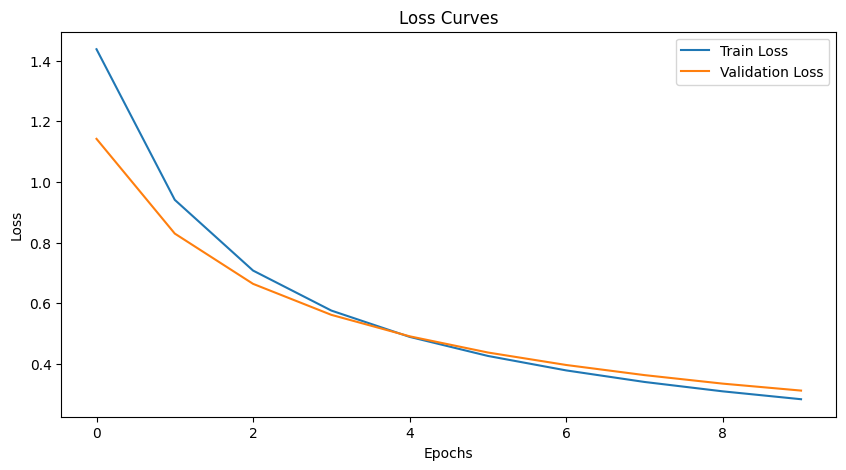

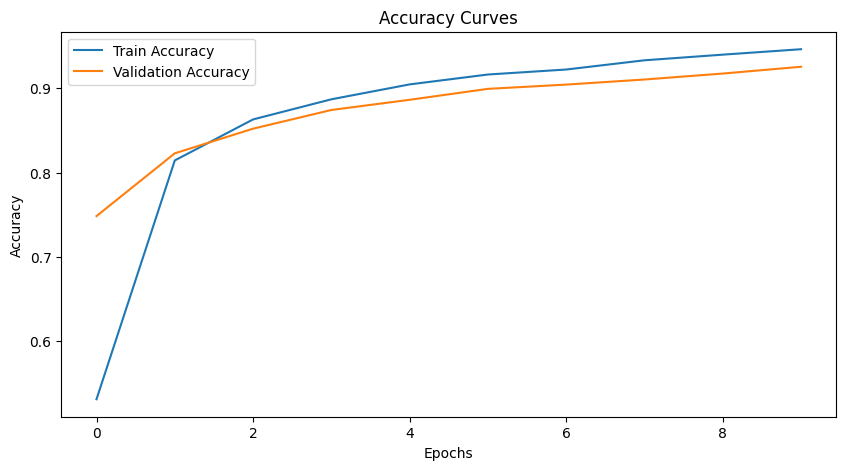

In [16]:
# Plot loss and accuracy curves
def plot_detailed_curves(results):
    epochs = range(len(results['train_loss']))

    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, results['train_loss'], label='Train Loss')
    plt.plot(epochs, results['test_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, results['train_acc'], label='Train Accuracy')
    plt.plot(epochs, results['test_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_detailed_curves(results)

In [17]:
# Save the trained model
model_save_path = "pretrained_vit_6_class.pth"
torch.save(pretrained_vit.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to pretrained_vit_6_class.pth


Evaluating model on test dataset...

Classification Report:
                  precision    recall  f1-score   support

          Aphids       0.92      0.89      0.91       164
       Army worm       0.98      0.95      0.97       162
Bacterial blight       0.92      0.91      0.91       160
         Healthy       0.95      0.98      0.96       165
  Powdery mildew       0.95      0.93      0.94       166
     Target spot       0.84      0.89      0.87       160

        accuracy                           0.93       977
       macro avg       0.93      0.93      0.93       977
    weighted avg       0.93      0.93      0.93       977



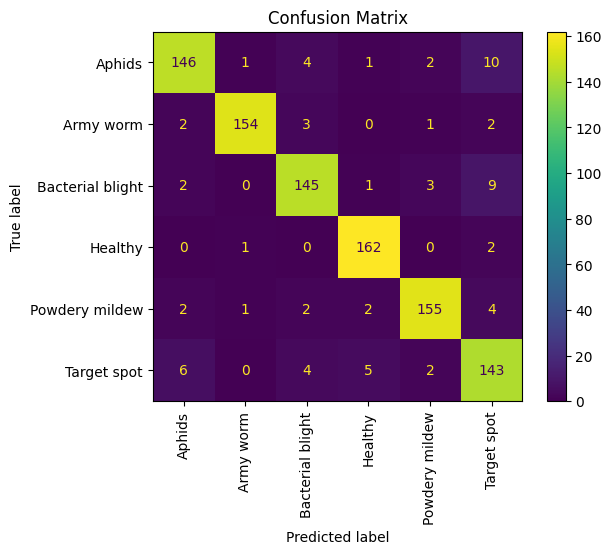

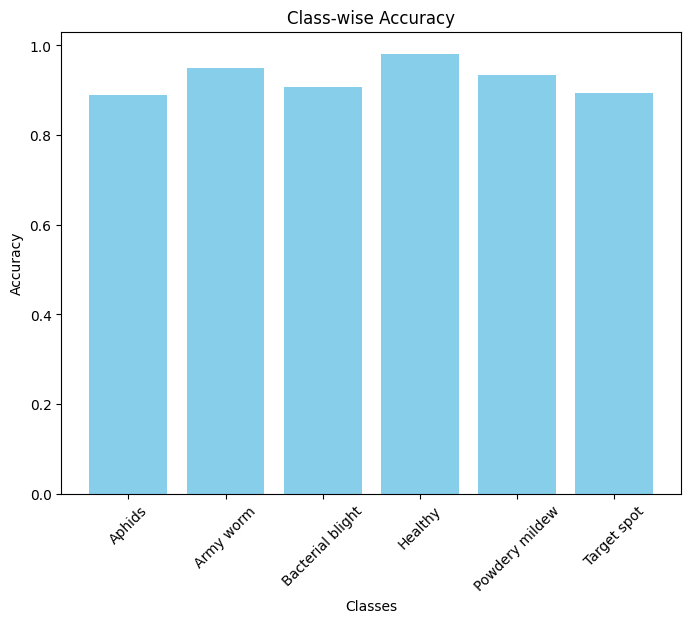

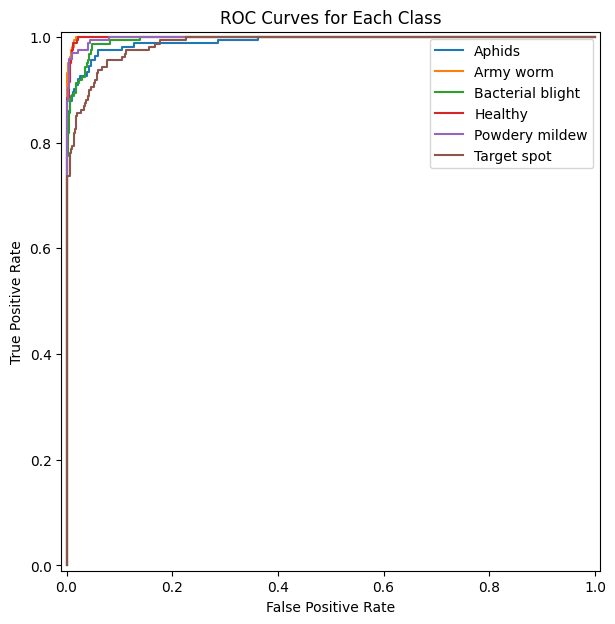

In [30]:
# Evaluate the model and visualize results
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="viridis", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    # Class-wise accuracy
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, accuracy_per_class, color='skyblue')
    plt.title("Class-wise Accuracy")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.show()

    # ROC Curves for each class
    from sklearn.metrics import roc_curve, RocCurveDisplay
    y_true_bin = label_binarize(all_labels, classes=range(len(class_names)))
    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(all_probs)[:, i])
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=None, estimator_name=class_name).plot(ax=plt.gca())
    plt.title("ROC Curves for Each Class")
    plt.legend(loc="best")
    plt.show()

print("Evaluating model on test dataset...")
evaluate_model(pretrained_vit, test_dataloader, class_names)


Predicting on image: /content/army.jpeg


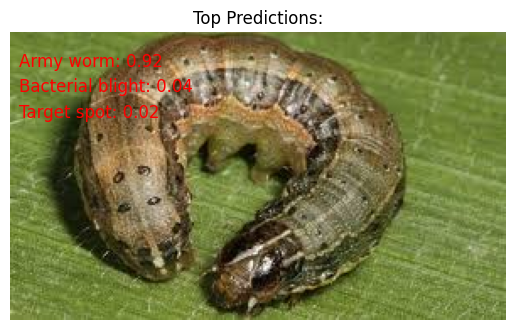

In [28]:
# Predict and visualize for a single image
from PIL import Image
from torchvision.transforms import Compose

def predict_and_visualize(model, image_path, class_names, transform, top_n=3):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(transformed_image)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        top_n_indices = probs.argsort()[-top_n:][::-1]

    plt.imshow(image)
    plt.title("Top Predictions:")
    for i, idx in enumerate(top_n_indices):
        plt.text(5, 20 + i * 15, f"{class_names[idx]}: {probs[idx]:.2f}", fontsize=12, color="red")
    plt.axis("off")
    plt.show()

# Predict on a new image
new_image_path = "/content/army.jpeg"
print(f"Predicting on image: {new_image_path}")
predict_and_visualize(pretrained_vit, new_image_path, class_names, pretrained_vit_transforms)

Predicting on image: /content/aphids.jpg


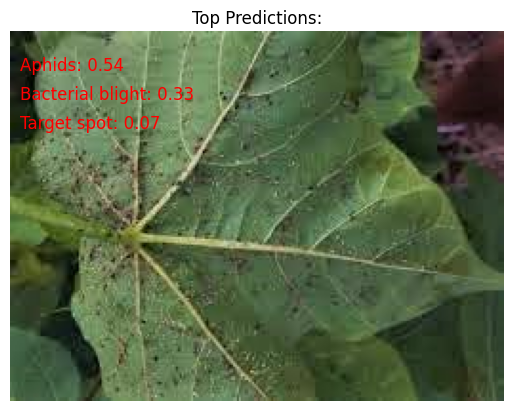

In [31]:
# Predict and visualize for a single image
from PIL import Image
from torchvision.transforms import Compose

def predict_and_visualize(model, image_path, class_names, transform, top_n=3):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(transformed_image)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        top_n_indices = probs.argsort()[-top_n:][::-1]

    plt.imshow(image)
    plt.title("Top Predictions:")
    for i, idx in enumerate(top_n_indices):
        plt.text(5, 20 + i * 15, f"{class_names[idx]}: {probs[idx]:.2f}", fontsize=12, color="red")
    plt.axis("off")
    plt.show()

# Predict on a new image
new_image_path = "/content/aphids.jpg"
print(f"Predicting on image: {new_image_path}")
predict_and_visualize(pretrained_vit, new_image_path, class_names, pretrained_vit_transforms)